# 05: Multiple-Patch Model Training
This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.

## 1. Imports & Dependencies
(imports os, numpy, torch, torchvision, timm, PIL, GroupShuffleSplit)

In [1]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

## 2. Define dataset class producing all patches
(class MultiPatchDataset)

In [2]:
class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        # Store patch metadata instead of actual images
        self.patch_info = []  # Will store (img_path, label, painting_id, crop_box)
        self.all_patches = []  # Keep for backward compatibility - will store (None, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter

                try:
                    # Only open image to get dimensions, don't keep it in memory
                    with Image.open(img_path) as img:
                        w, h = img.size

                    if w == 0 or h == 0:
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    max_dim = max(w, h)
                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0:
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    # Store crop coordinates instead of actual patches
                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            if (right - left) > 0 and (bottom - upper) > 0:
                                crop_box = (left, upper, right, bottom)
                                self.patch_info.append((img_path, label, current_painting_id, crop_box))
                                # Keep backward compatibility with all_patches
                                self.all_patches.append((None, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.patch_info:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.patch_info)} patch coordinates from {painting_id_counter} paintings.")

    def __len__(self):
        return len(self.patch_info)

    def __getitem__(self, idx):
        img_path, label, painting_id, crop_box = self.patch_info[idx]
        
        try:
            # Load and crop image on-demand
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                patch_img = img.crop(crop_box)
            
            transformed_patch = self.transform(patch_img)
            
        except Exception as e:
            print(f"Error loading/transforming patch (index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            
        return transformed_patch, label, painting_id

## 3. Define Device, Prepare Dataset & Splits, Calculate Class Weights

In [3]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Update this path to your dataset location
root_dir = '/kaggle/input/vangogh-run5/run_5'
ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
groups = [pid for _, _, pid in ds.all_patches]

# Split data with GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ds.all_patches, groups=groups))

print(f"Train samples: {len(train_idx)} | Val samples: {len(val_idx)}")
print(f"Classes: {list(ds.class_to_idx.keys())}")

# Excel tracking function
csv_path = "/kaggle/input/csv-file/vg_imgs_aug11_Adi_updated.csv"  

def track_split_during_processing(csv_path, root_dir, ds, train_idx, val_idx):
    
    print("Updating Excel file with train/val split...")
    df = pd.read_csv(csv_path)
    
    df['run_5_train_val_images'] = ''
    
    painting_id_to_info = {}
    painting_id_counter = 0
    
    for class_name in ds.defined_classes:
        class_path = Path(root_dir) / class_name
        if not class_path.is_dir():
            continue
            
        image_files = sorted([f for f in class_path.iterdir() 
                            if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        
        for img_file in image_files:
            painting_id_to_info[painting_id_counter] = img_file.name
            painting_id_counter += 1
    
    train_painting_ids = {ds.all_patches[idx][2] for idx in train_idx}
    val_painting_ids = {ds.all_patches[idx][2] for idx in val_idx}
    
    train_filenames = {painting_id_to_info[pid] for pid in train_painting_ids if pid in painting_id_to_info}
    val_filenames = {painting_id_to_info[pid] for pid in val_painting_ids if pid in painting_id_to_info}

    for idx, row in df.iterrows():
        image_filename = row['image']
        if image_filename in train_filenames:
            df.loc[idx, 'run_5_train_val_images'] = 'train'
        elif image_filename in val_filenames:
            df.loc[idx, 'run_5_train_val_images'] = 'val'
    
    # Save updated file
    output_path = '/kaggle/working/vg_imgs_aug11_Adi_updated_with_train_val_split.csv'
    df.to_csv(output_path, index=False)
    
    split_counts = df['run_5_train_val_images'].value_counts()
    print(f"Updated Excel saved to: {output_path}")
    print(f"Train/Val split: {dict(split_counts)}")
    
    return output_path

updated_excel = track_split_during_processing(
    csv_path="/kaggle/input/csv-file/vg_imgs_aug11_Adi_updated.csv",  
    root_dir=root_dir,
    ds=ds,
    train_idx=train_idx,
    val_idx=val_idx
)

# Create subset datasets
train_dataset = Subset(ds, train_idx)
val_dataset = Subset(ds, val_idx)

# Sample weights for imbalance
train_labels_for_sampler = np.array([ds.all_patches[i][1] for i in train_idx])
weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels_for_sampler]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Calculate class weights for loss function
train_labels_for_class_weights = [ds.all_patches[i][1] for i in train_idx]
class_counts = Counter(train_labels_for_class_weights)
num_classes = len(ds.class_to_idx)

weights_list = [0.0] * num_classes
for class_idx, count in class_counts.items():
    if count > 0:
        weights_list[class_idx] = len(train_labels_for_class_weights) / (num_classes * count)
    else:
        weights_list[class_idx] = 1.0

class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)
print(f"Calculated class weights: {class_weights.tolist()}")

Using device: cuda
Dataset initialized. Root: '/kaggle/input/vangogh-run5/run_5', Class mapping: {'authentic': 0, 'imitation': 1}


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Generated 21141 patch coordinates from 1773 paintings.
Train samples: 17000 | Val samples: 4141
Classes: ['authentic', 'imitation']
Updating Excel file with train/val split...
Updated Excel saved to: /kaggle/working/vg_imgs_aug11_Adi_updated_with_train_val_split.csv
Train/Val split: {'train': 1414, '': 1251, 'val': 355}
Calculated class weights: [0.9767869710922241, 1.0243432521820068]


## 4. Model Setup 

In [4]:
print("--- Setting up EfficientNet with Normalization ---")

# Create model
model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2).to(device)

# Targeted Weight Initialization for Stability
def init_efficientnet_targeted(model):
    """Target only the problematic layers identified from activation analysis"""
    print("Applying targeted weight initialization to problematic EfficientNet layers...")
    
    for name, param in model.named_parameters():
        # Target classifier layers (showed high activation values)
        if 'classifier' in name and 'weight' in name:
            print(f"  Initializing {name} with very small weights (std=0.001)")
            nn.init.normal_(param, 0, 0.001)
        elif 'classifier' in name and 'bias' in name:
            nn.init.constant_(param, 0)
            
        # Target SE modules (showed high activation values)
        elif 'se.' in name and 'weight' in name:
            print(f"  Scaling down SE layer: {name}")
            param.data *= 0.1  # Scale down by 90%
            
        # Target problematic Block 6 conv_pw layers
        elif 'blocks.6' in name and 'conv_pw' in name and 'weight' in name:
            print(f"  Scaling down Block 6 conv_pw: {name}")
            param.data *= 0.5  # Scale down by 50%
            
        # Target conv_head
        elif 'conv_head' in name and 'weight' in name:
            print(f"  Scaling down conv_head: {name}")
            param.data *= 0.7  # Moderate scaling
    
    print("Targeted weight initialization complete.")

# Apply targeted initialization
init_efficientnet_targeted(model)

# Warmup Learning Rate Scheduler
class WarmupLRScheduler:
    def __init__(self, optimizer, base_lr=1e-6, warmup_epochs=5, warmup_start_factor=0.1):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.warmup_start_factor = warmup_start_factor
        self.current_epoch = 0
        
    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup from start_factor to 1.0
            warmup_progress = epoch / self.warmup_epochs
            factor = self.warmup_start_factor + (1.0 - self.warmup_start_factor) * warmup_progress
            return self.base_lr * factor
        else:
            return self.base_lr
    
    def step(self, epoch):
        self.current_epoch = epoch
        lr = self.get_lr(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

# Loss function with class weights and label smoothing
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

# Optimizer with warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)

# Create warmup scheduler
warmup_scheduler = WarmupLRScheduler(
    optimizer=optimizer,
    base_lr=1e-6,
    warmup_epochs=5,
    warmup_start_factor=0.1
)

print(f"EfficientNet warmup scheduler created:")
print(f"  Start LR: {warmup_scheduler.base_lr * warmup_scheduler.warmup_start_factor:.2e}")
print(f"  Target LR: {warmup_scheduler.base_lr:.2e}")
print(f"  Warmup epochs: {warmup_scheduler.warmup_epochs}")


--- Setting up EfficientNet with Normalization ---


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Applying targeted weight initialization to problematic EfficientNet layers...
  Scaling down SE layer: blocks.0.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.0.se.conv_expand.weight
  Scaling down SE layer: blocks.0.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.1.se.conv_expand.weight
  Scaling down SE layer: blocks.0.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.0.se.conv_expand.weight
  Scaling down SE layer: blocks.1.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.1.se.conv_expand.weight
  Scaling down SE layer: blocks.1.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.3.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.3.se.conv_expand.weight
  Scaling down SE layer: blocks.1.4.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.4.se.conv_expand.w

## 5. Training Functions

In [5]:
def train_one_epoch(model, loader, optimizer, epoch=None, print_every=50):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()

        # Gradient clipping for stability
        grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item() * x.size(0)

        preds = out.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().tolist())

        if epoch is not None and batch_idx % print_every == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, all_labels, all_preds

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Class balance print
    y_true = list(group_labels.values())
    print(f"Validation class distribution: {sum(y_true)}/{len(y_true)} positives")

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

def save_training_results(model_name, train_metrics, val_metrics, val_loss_metrics, timestamp):
    """Save detailed training results to a JSON file"""
    results = {
        "model_name": model_name,
        "timestamp": timestamp,
        "training_loss": train_metrics,
        "validation_accuracy": val_metrics,
        "validation_loss": val_loss_metrics
    }
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{timestamp}_run5.json"
    os.makedirs(os.path.dirname(json_path), exist_ok=True)
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Detailed results saved to {json_path}")

## 6. Training Loop


--- Starting EfficientNet Training for 30 Epochs ---

===== EPOCH 1/30 =====
EfficientNet LR for epoch 1: 1.00e-07

Training EfficientNet for Epoch 1...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 1 | Batch 50/1063 | Loss 0.688570


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 1 | Batch 100/1063 | Loss 0.691980


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 150/1063 | Loss 0.680541


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 1 | Batch 200/1063 | Loss 0.670984


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 250/1063 | Loss 0.692014


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 300/1063 | Loss 0.675677


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 350/1063 | Loss 0.690959


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 400/1063 | Loss 0.676275


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 450/1063 | Loss 0.673274


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 500/1063 | Loss 0.668097


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 550/1063 | Loss 0.691594
Epoch 1 | Batch 600/1063 | Loss 0.660887


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 650/1063 | Loss 0.670067
Epoch 1 | Batch 700/1063 | Loss 0.674986
Epoch 1 | Batch 750/1063 | Loss 0.673478
Epoch 1 | Batch 800/1063 | Loss 0.670996
Epoch 1 | Batch 850/1063 | Loss 0.694450
Epoch 1 | Batch 900/1063 | Loss 0.668225
Epoch 1 | Batch 950/1063 | Loss 0.666381
Epoch 1 | Batch 1000/1063 | Loss 0.656084
Epoch 1 | Batch 1050/1063 | Loss 0.663204
Validating EfficientNet for Epoch 1...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 1/30 | Train Loss: 0.677141 | Val Acc: 0.671094 | Val Loss: 0.662667


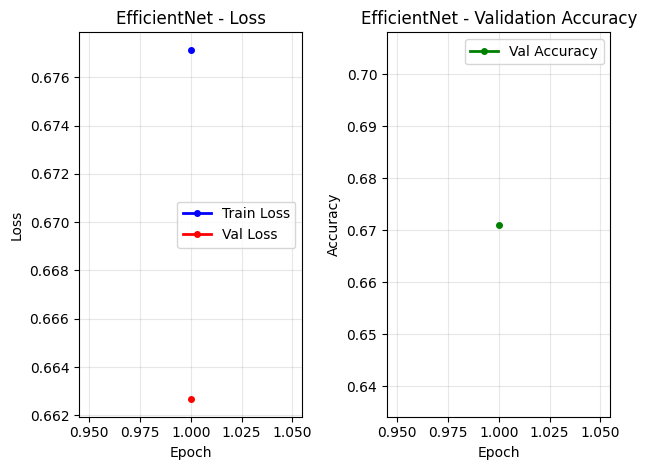


===== EPOCH 2/30 =====
EfficientNet LR for epoch 2: 2.80e-07

Training EfficientNet for Epoch 2...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 2 | Batch 50/1063 | Loss 0.647954


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 2 | Batch 100/1063 | Loss 0.637009


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 150/1063 | Loss 0.651824


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 2 | Batch 200/1063 | Loss 0.647522


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 250/1063 | Loss 0.645900


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 300/1063 | Loss 0.657580


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 350/1063 | Loss 0.600440


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 400/1063 | Loss 0.631289
Epoch 2 | Batch 450/1063 | Loss 0.630815


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 500/1063 | Loss 0.584946
Epoch 2 | Batch 550/1063 | Loss 0.581947
Epoch 2 | Batch 600/1063 | Loss 0.625181


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 650/1063 | Loss 0.647534
Epoch 2 | Batch 700/1063 | Loss 0.582936


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 750/1063 | Loss 0.616454
Epoch 2 | Batch 800/1063 | Loss 0.649361
Epoch 2 | Batch 850/1063 | Loss 0.579047
Epoch 2 | Batch 900/1063 | Loss 0.590750
Epoch 2 | Batch 950/1063 | Loss 0.616047
Epoch 2 | Batch 1000/1063 | Loss 0.550674
Epoch 2 | Batch 1050/1063 | Loss 0.549853
Validating EfficientNet for Epoch 2...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 2/30 | Train Loss: 0.619717 | Val Acc: 0.807534 | Val Loss: 0.582354


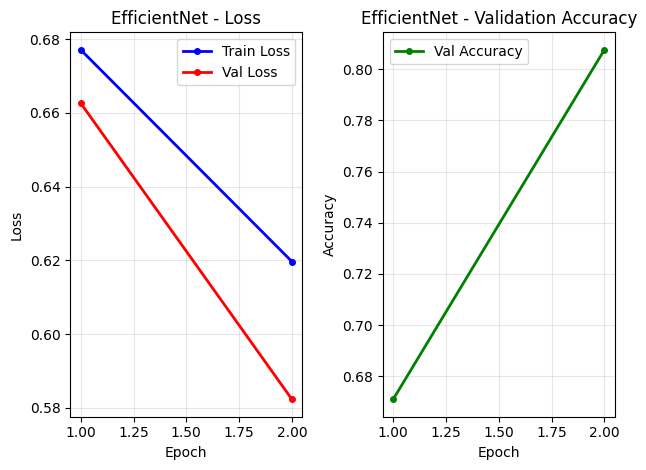


===== EPOCH 3/30 =====
EfficientNet LR for epoch 3: 4.60e-07

Training EfficientNet for Epoch 3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 50/1063 | Loss 0.576896


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 3 | Batch 100/1063 | Loss 0.599094


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 150/1063 | Loss 0.567277


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 200/1063 | Loss 0.519138


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 250/1063 | Loss 0.545591


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 300/1063 | Loss 0.529609
Epoch 3 | Batch 350/1063 | Loss 0.600285
Epoch 3 | Batch 400/1063 | Loss 0.501716


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 450/1063 | Loss 0.473563
Epoch 3 | Batch 500/1063 | Loss 0.706360


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 550/1063 | Loss 0.519947


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 600/1063 | Loss 0.547693


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 650/1063 | Loss 0.568256
Epoch 3 | Batch 700/1063 | Loss 0.520775
Epoch 3 | Batch 750/1063 | Loss 0.575855


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 800/1063 | Loss 0.420158
Epoch 3 | Batch 850/1063 | Loss 0.464722
Epoch 3 | Batch 900/1063 | Loss 0.565865
Epoch 3 | Batch 950/1063 | Loss 0.486709


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 1000/1063 | Loss 0.537382
Epoch 3 | Batch 1050/1063 | Loss 0.638762
Validating EfficientNet for Epoch 3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 3/30 | Train Loss: 0.532361 | Val Acc: 0.855590 | Val Loss: 0.506286


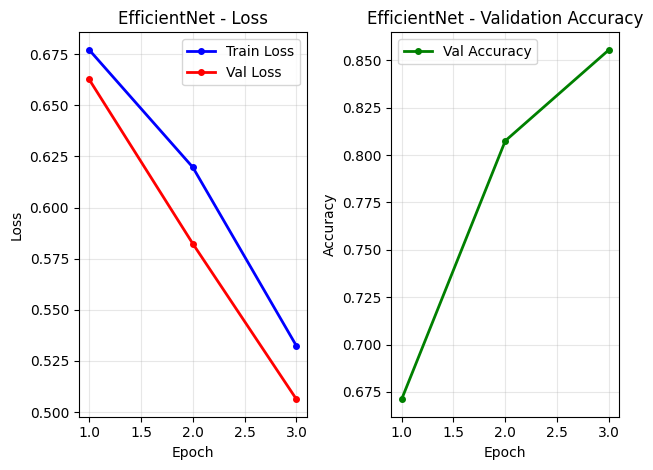


===== EPOCH 4/30 =====
EfficientNet LR for epoch 4: 6.40e-07

Training EfficientNet for Epoch 4...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 4 | Batch 50/1063 | Loss 0.437187


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 100/1063 | Loss 0.418132


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 150/1063 | Loss 0.490970


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 200/1063 | Loss 0.436890


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 250/1063 | Loss 0.488586


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 300/1063 | Loss 0.405624
Epoch 4 | Batch 350/1063 | Loss 0.395977


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 400/1063 | Loss 0.438527


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 450/1063 | Loss 0.378104
Epoch 4 | Batch 500/1063 | Loss 0.423301
Epoch 4 | Batch 550/1063 | Loss 0.405732
Epoch 4 | Batch 600/1063 | Loss 0.523818
Epoch 4 | Batch 650/1063 | Loss 0.485286


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 700/1063 | Loss 0.355993


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 750/1063 | Loss 0.405966


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 800/1063 | Loss 0.385279
Epoch 4 | Batch 850/1063 | Loss 0.335522
Epoch 4 | Batch 900/1063 | Loss 0.351083
Epoch 4 | Batch 950/1063 | Loss 0.454974


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 1000/1063 | Loss 0.450325


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 1050/1063 | Loss 0.359222
Validating EfficientNet for Epoch 4...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 4/30 | Train Loss: 0.461496 | Val Acc: 0.872978 | Val Loss: 0.439602


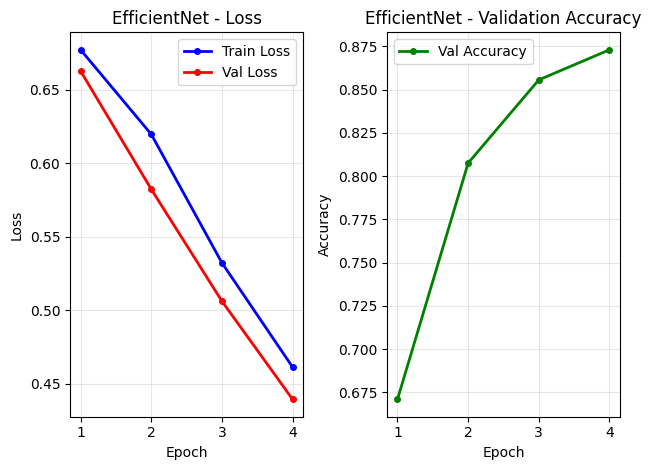


===== EPOCH 5/30 =====
EfficientNet LR for epoch 5: 8.20e-07

Training EfficientNet for Epoch 5...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 5 | Batch 50/1063 | Loss 0.320815


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 100/1063 | Loss 0.523299


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 150/1063 | Loss 0.434001


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 200/1063 | Loss 0.333230


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 5 | Batch 250/1063 | Loss 0.438657


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 300/1063 | Loss 0.340490


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 350/1063 | Loss 0.359281


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 400/1063 | Loss 0.522185


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 450/1063 | Loss 0.382679
Epoch 5 | Batch 500/1063 | Loss 0.436286
Epoch 5 | Batch 550/1063 | Loss 0.302988


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 600/1063 | Loss 0.465429
Epoch 5 | Batch 650/1063 | Loss 0.412782
Epoch 5 | Batch 700/1063 | Loss 0.297574


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 750/1063 | Loss 0.400328
Epoch 5 | Batch 800/1063 | Loss 0.350693
Epoch 5 | Batch 850/1063 | Loss 0.284863
Epoch 5 | Batch 900/1063 | Loss 0.322623
Epoch 5 | Batch 950/1063 | Loss 0.344587
Epoch 5 | Batch 1000/1063 | Loss 0.457401


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 1050/1063 | Loss 0.843492
Validating EfficientNet for Epoch 5...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 5/30 | Train Loss: 0.377851 | Val Acc: 0.888916 | Val Loss: 0.386097


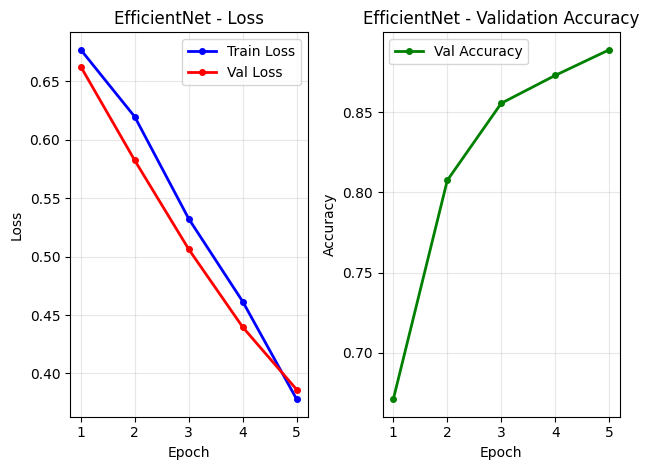


===== EPOCH 6/30 =====
EfficientNet LR for epoch 6: 1.00e-06

Training EfficientNet for Epoch 6...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 6 | Batch 50/1063 | Loss 0.222162


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 6 | Batch 100/1063 | Loss 0.334316


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 150/1063 | Loss 0.247490


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 200/1063 | Loss 0.228648


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 250/1063 | Loss 0.261006


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 300/1063 | Loss 0.263297


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 350/1063 | Loss 0.453055


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 400/1063 | Loss 0.202488


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 450/1063 | Loss 0.274569
Epoch 6 | Batch 500/1063 | Loss 0.543704
Epoch 6 | Batch 550/1063 | Loss 0.244728


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 600/1063 | Loss 0.619207


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 650/1063 | Loss 0.280295


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 700/1063 | Loss 0.425995
Epoch 6 | Batch 750/1063 | Loss 0.275403
Epoch 6 | Batch 800/1063 | Loss 0.390007
Epoch 6 | Batch 850/1063 | Loss 0.261124


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 900/1063 | Loss 0.341409
Epoch 6 | Batch 950/1063 | Loss 0.176053
Epoch 6 | Batch 1000/1063 | Loss 0.308609


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 1050/1063 | Loss 0.182047
Validating EfficientNet for Epoch 6...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
Warmup complete! Switching to ReduceLROnPlateau scheduler...
RESULTS: EfficientNet | Epoch 6/30 | Train Loss: 0.325890 | Val Acc: 0.903405 | Val Loss: 0.322636


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


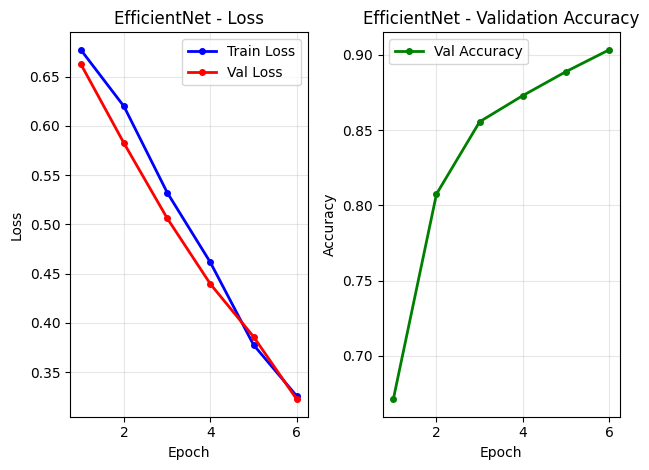


===== EPOCH 7/30 =====
EfficientNet LR for epoch 7: 1.00e-06

Training EfficientNet for Epoch 7...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Epoch 7 | Batch 50/1063 | Loss 0.214539
Epoch 7 | Batch 100/1063 | Loss 0.516879


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 150/1063 | Loss 0.550996


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 200/1063 | Loss 0.265713


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 250/1063 | Loss 0.353310


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 300/1063 | Loss 0.199723


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 350/1063 | Loss 0.262169
Epoch 7 | Batch 400/1063 | Loss 0.428583


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 450/1063 | Loss 0.234346


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 500/1063 | Loss 0.220406
Epoch 7 | Batch 550/1063 | Loss 0.272715


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 600/1063 | Loss 0.157503
Epoch 7 | Batch 650/1063 | Loss 0.174983
Epoch 7 | Batch 700/1063 | Loss 0.287592


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 750/1063 | Loss 0.245613


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 800/1063 | Loss 0.204546


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 850/1063 | Loss 0.348111
Epoch 7 | Batch 900/1063 | Loss 0.321625
Epoch 7 | Batch 950/1063 | Loss 0.327933
Epoch 7 | Batch 1000/1063 | Loss 0.523444
Epoch 7 | Batch 1050/1063 | Loss 0.138360
Validating EfficientNet for Epoch 7...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 7/30 | Train Loss: 0.274924 | Val Acc: 0.905820 | Val Loss: 0.294560


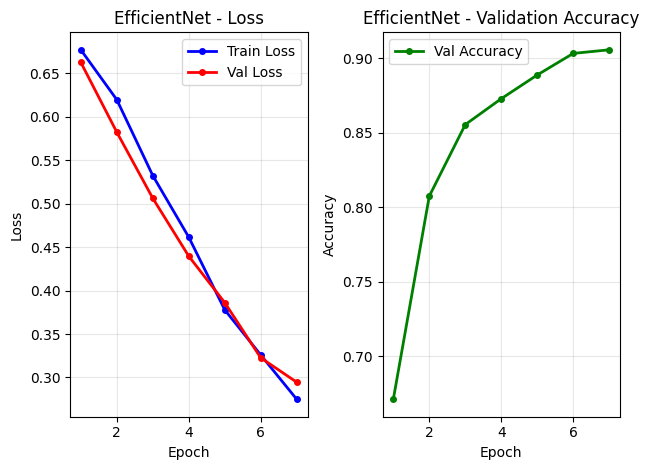


===== EPOCH 8/30 =====
EfficientNet LR for epoch 8: 1.00e-06

Training EfficientNet for Epoch 8...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 8 | Batch 50/1063 | Loss 0.196330


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 8 | Batch 100/1063 | Loss 0.163634


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 150/1063 | Loss 0.211945


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 8 | Batch 200/1063 | Loss 0.311219


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 250/1063 | Loss 0.142264
Epoch 8 | Batch 300/1063 | Loss 0.431730


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 350/1063 | Loss 0.750446
Epoch 8 | Batch 400/1063 | Loss 0.290291


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 450/1063 | Loss 0.443849


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 500/1063 | Loss 0.498523
Epoch 8 | Batch 550/1063 | Loss 0.563468


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 600/1063 | Loss 0.183323


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 650/1063 | Loss 0.155409


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 700/1063 | Loss 0.277990
Epoch 8 | Batch 750/1063 | Loss 0.371139


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 800/1063 | Loss 0.347393
Epoch 8 | Batch 850/1063 | Loss 0.150165
Epoch 8 | Batch 900/1063 | Loss 0.139636
Epoch 8 | Batch 950/1063 | Loss 0.592316
Epoch 8 | Batch 1000/1063 | Loss 0.351620
Epoch 8 | Batch 1050/1063 | Loss 0.111801
Validating EfficientNet for Epoch 8...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 8/30 | Train Loss: 0.251628 | Val Acc: 0.906303 | Val Loss: 0.295106


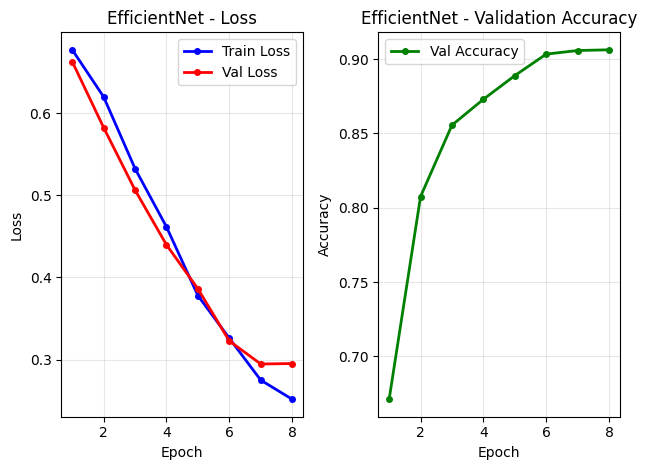


===== EPOCH 9/30 =====
EfficientNet LR for epoch 9: 1.00e-06

Training EfficientNet for Epoch 9...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 9 | Batch 50/1063 | Loss 0.144607


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 100/1063 | Loss 0.325113


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 150/1063 | Loss 0.470691


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 9 | Batch 200/1063 | Loss 0.465387


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 250/1063 | Loss 0.205461
Epoch 9 | Batch 300/1063 | Loss 0.152566


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 350/1063 | Loss 0.176573


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 400/1063 | Loss 0.139840


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 450/1063 | Loss 0.233352
Epoch 9 | Batch 500/1063 | Loss 0.318374


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 550/1063 | Loss 0.302611


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 600/1063 | Loss 0.308240
Epoch 9 | Batch 650/1063 | Loss 0.137088
Epoch 9 | Batch 700/1063 | Loss 0.202150
Epoch 9 | Batch 750/1063 | Loss 0.105487
Epoch 9 | Batch 800/1063 | Loss 0.218443
Epoch 9 | Batch 850/1063 | Loss 0.545205
Epoch 9 | Batch 900/1063 | Loss 0.167401
Epoch 9 | Batch 950/1063 | Loss 0.618698
Epoch 9 | Batch 1000/1063 | Loss 0.278244
Epoch 9 | Batch 1050/1063 | Loss 0.190472
Validating EfficientNet for Epoch 9...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 9/30 | Train Loss: 0.239676 | Val Acc: 0.892780 | Val Loss: 0.318065


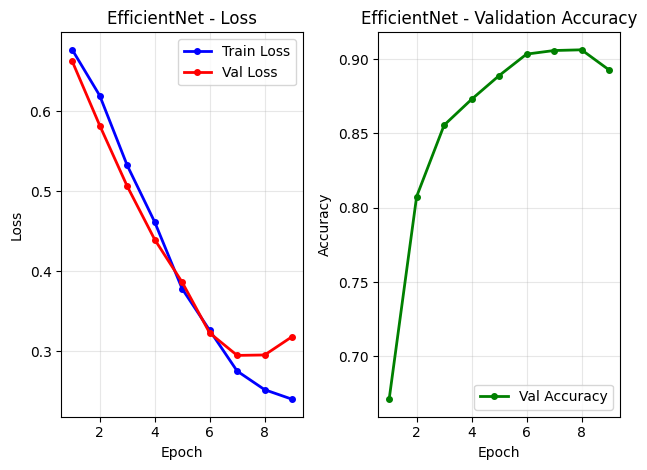


===== EPOCH 10/30 =====
EfficientNet LR for epoch 10: 1.00e-06

Training EfficientNet for Epoch 10...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Epoch 10 | Batch 50/1063 | Loss 0.130363


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 100/1063 | Loss 0.230650


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 10 | Batch 150/1063 | Loss 0.245816


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 200/1063 | Loss 0.174793


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 250/1063 | Loss 0.183248


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 10 | Batch 300/1063 | Loss 0.230325


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 350/1063 | Loss 0.159874
Epoch 10 | Batch 400/1063 | Loss 0.405148


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 450/1063 | Loss 0.302508
Epoch 10 | Batch 500/1063 | Loss 0.111592
Epoch 10 | Batch 550/1063 | Loss 0.232204
Epoch 10 | Batch 600/1063 | Loss 0.299106


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 650/1063 | Loss 0.098338
Epoch 10 | Batch 700/1063 | Loss 0.133780
Epoch 10 | Batch 750/1063 | Loss 0.188796
Epoch 10 | Batch 800/1063 | Loss 0.233043
Epoch 10 | Batch 850/1063 | Loss 0.245214
Epoch 10 | Batch 900/1063 | Loss 0.085629
Epoch 10 | Batch 950/1063 | Loss 0.151002


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 1000/1063 | Loss 0.236834
Epoch 10 | Batch 1050/1063 | Loss 0.325516
Validating EfficientNet for Epoch 10...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 10/30 | Train Loss: 0.225030 | Val Acc: 0.902681 | Val Loss: 0.318624


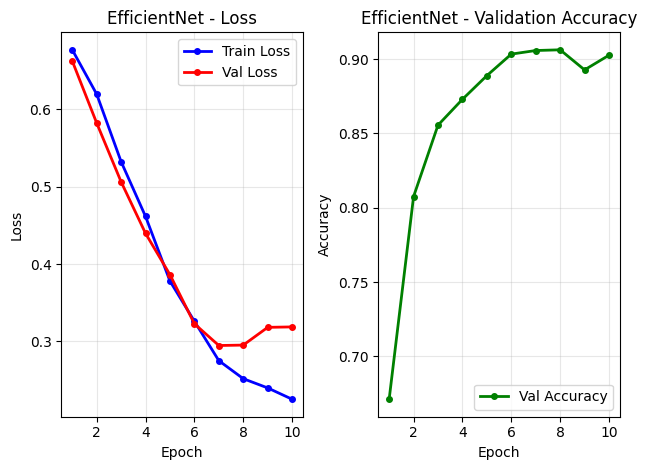


===== EPOCH 11/30 =====
EfficientNet LR for epoch 11: 1.00e-06

Training EfficientNet for Epoch 11...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 11 | Batch 50/1063 | Loss 0.356546


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 11 | Batch 100/1063 | Loss 0.169187


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 150/1063 | Loss 0.187611


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 200/1063 | Loss 0.306643


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 250/1063 | Loss 0.450077


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 300/1063 | Loss 0.136068


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 350/1063 | Loss 0.188106


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 400/1063 | Loss 0.348588


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 450/1063 | Loss 0.258331


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 500/1063 | Loss 0.323373
Epoch 11 | Batch 550/1063 | Loss 0.206738


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 600/1063 | Loss 0.368409


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 650/1063 | Loss 0.071957


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 700/1063 | Loss 0.135127


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 750/1063 | Loss 0.081308
Epoch 11 | Batch 800/1063 | Loss 0.167503
Epoch 11 | Batch 850/1063 | Loss 0.160083
Epoch 11 | Batch 900/1063 | Loss 0.130688
Epoch 11 | Batch 950/1063 | Loss 0.131607


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 1000/1063 | Loss 0.518984
Epoch 11 | Batch 1050/1063 | Loss 0.146224
Validating EfficientNet for Epoch 11...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 11/30 | Train Loss: 0.210621 | Val Acc: 0.905337 | Val Loss: 0.336211


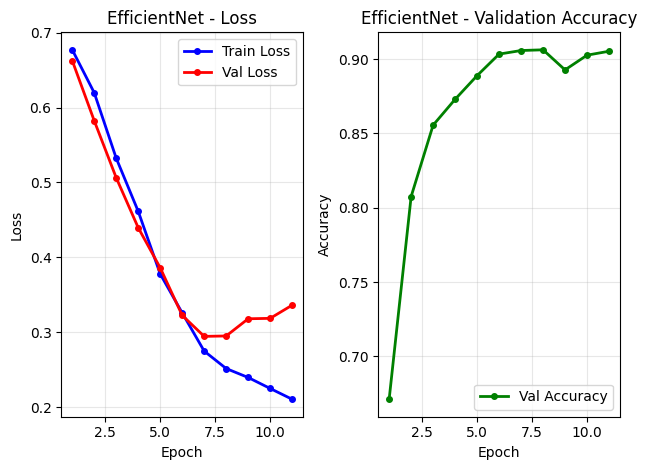


===== EPOCH 12/30 =====
EfficientNet LR for epoch 12: 1.00e-06

Training EfficientNet for Epoch 12...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 12 | Batch 50/1063 | Loss 0.174419


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 100/1063 | Loss 0.331334


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 12 | Batch 150/1063 | Loss 0.195127


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 200/1063 | Loss 0.391508


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 250/1063 | Loss 0.168077


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 300/1063 | Loss 0.175896


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 350/1063 | Loss 0.151518


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 400/1063 | Loss 0.116410


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 450/1063 | Loss 0.440364


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 500/1063 | Loss 0.075098
Epoch 12 | Batch 550/1063 | Loss 0.150201
Epoch 12 | Batch 600/1063 | Loss 0.343072


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 650/1063 | Loss 0.252593
Epoch 12 | Batch 700/1063 | Loss 0.075452


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 750/1063 | Loss 0.102868
Epoch 12 | Batch 800/1063 | Loss 0.076168


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 850/1063 | Loss 0.181044
Epoch 12 | Batch 900/1063 | Loss 0.182237
Epoch 12 | Batch 950/1063 | Loss 0.072385
Epoch 12 | Batch 1000/1063 | Loss 0.106144
Epoch 12 | Batch 1050/1063 | Loss 0.133725
Validating EfficientNet for Epoch 12...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 12/30 | Train Loss: 0.203201 | Val Acc: 0.915479 | Val Loss: 0.286437


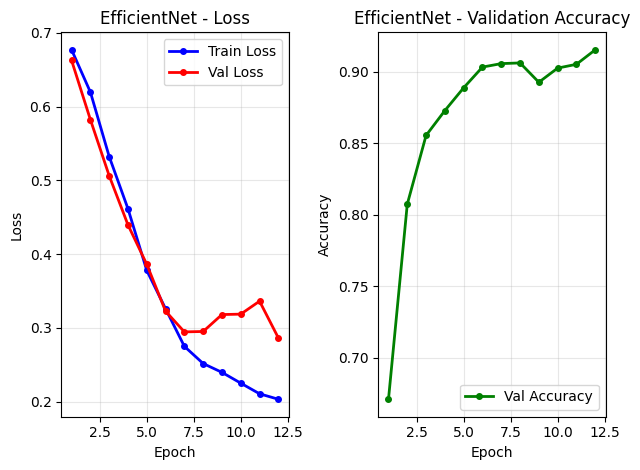


===== EPOCH 13/30 =====
EfficientNet LR for epoch 13: 1.00e-06

Training EfficientNet for Epoch 13...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 50/1063 | Loss 0.271679


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 13 | Batch 100/1063 | Loss 0.490222


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 13 | Batch 150/1063 | Loss 0.128356


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 200/1063 | Loss 0.352799


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 250/1063 | Loss 0.385747


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 300/1063 | Loss 0.078718


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 350/1063 | Loss 0.134565


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 400/1063 | Loss 0.068025


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 450/1063 | Loss 0.214438
Epoch 13 | Batch 500/1063 | Loss 0.218604


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 550/1063 | Loss 0.064720


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 600/1063 | Loss 0.085812


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 650/1063 | Loss 0.126692


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 700/1063 | Loss 0.310460
Epoch 13 | Batch 750/1063 | Loss 0.091128


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 800/1063 | Loss 0.079464
Epoch 13 | Batch 850/1063 | Loss 0.130808


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 900/1063 | Loss 0.191494
Epoch 13 | Batch 950/1063 | Loss 0.080003
Epoch 13 | Batch 1000/1063 | Loss 0.194676
Epoch 13 | Batch 1050/1063 | Loss 0.320851
Validating EfficientNet for Epoch 13...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 13/30 | Train Loss: 0.189022 | Val Acc: 0.904371 | Val Loss: 0.327162


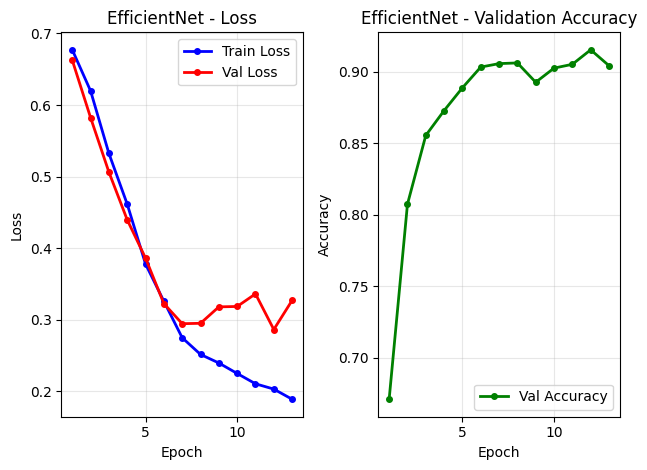


===== EPOCH 14/30 =====
EfficientNet LR for epoch 14: 1.00e-06

Training EfficientNet for Epoch 14...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 14 | Batch 50/1063 | Loss 0.168327


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 14 | Batch 100/1063 | Loss 0.076135


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 150/1063 | Loss 0.326938


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 200/1063 | Loss 0.260991


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 250/1063 | Loss 0.085137


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 300/1063 | Loss 0.222770


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 350/1063 | Loss 0.204702


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 400/1063 | Loss 0.188839


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 450/1063 | Loss 0.063277


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 500/1063 | Loss 0.121385


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 550/1063 | Loss 0.076827


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 600/1063 | Loss 0.097666
Epoch 14 | Batch 650/1063 | Loss 0.271540
Epoch 14 | Batch 700/1063 | Loss 0.060443
Epoch 14 | Batch 750/1063 | Loss 0.160707
Epoch 14 | Batch 800/1063 | Loss 0.565378
Epoch 14 | Batch 850/1063 | Loss 0.185690
Epoch 14 | Batch 900/1063 | Loss 0.148853
Epoch 14 | Batch 950/1063 | Loss 0.405394
Epoch 14 | Batch 1000/1063 | Loss 0.092217
Epoch 14 | Batch 1050/1063 | Loss 0.141146
Validating EfficientNet for Epoch 14...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 14/30 | Train Loss: 0.176028 | Val Acc: 0.905820 | Val Loss: 0.324179


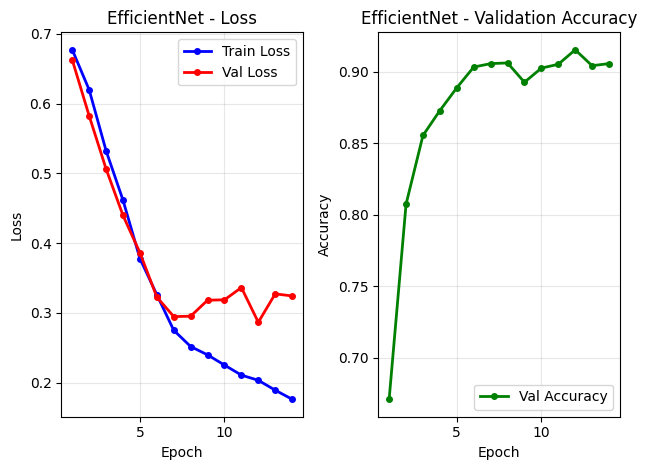


===== EPOCH 15/30 =====
EfficientNet LR for epoch 15: 1.00e-06

Training EfficientNet for Epoch 15...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 15 | Batch 50/1063 | Loss 0.261851


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 15 | Batch 100/1063 | Loss 0.154047


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 150/1063 | Loss 0.120751


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 200/1063 | Loss 0.082200


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 250/1063 | Loss 0.139969


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 300/1063 | Loss 0.286959


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 350/1063 | Loss 0.177003


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 400/1063 | Loss 0.070065
Epoch 15 | Batch 450/1063 | Loss 0.062355


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 500/1063 | Loss 0.073708
Epoch 15 | Batch 550/1063 | Loss 0.266772
Epoch 15 | Batch 600/1063 | Loss 0.143877


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 650/1063 | Loss 0.071074
Epoch 15 | Batch 700/1063 | Loss 0.557347


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 750/1063 | Loss 0.265101
Epoch 15 | Batch 800/1063 | Loss 0.087434
Epoch 15 | Batch 850/1063 | Loss 0.180280
Epoch 15 | Batch 900/1063 | Loss 0.171543
Epoch 15 | Batch 950/1063 | Loss 0.090942
Epoch 15 | Batch 1000/1063 | Loss 0.160275
Epoch 15 | Batch 1050/1063 | Loss 0.153834
Validating EfficientNet for Epoch 15...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 15/30 | Train Loss: 0.167224 | Val Acc: 0.918619 | Val Loss: 0.271456


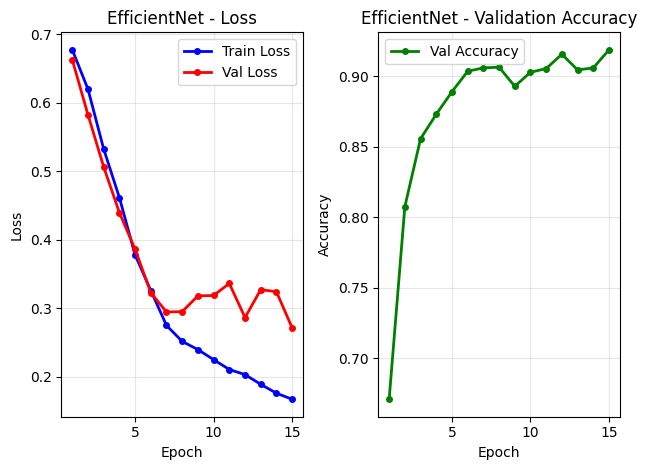


===== EPOCH 16/30 =====
EfficientNet LR for epoch 16: 1.00e-06

Training EfficientNet for Epoch 16...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 50/1063 | Loss 0.133356


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 100/1063 | Loss 0.103014


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 16 | Batch 150/1063 | Loss 0.079221


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 200/1063 | Loss 0.079387


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 250/1063 | Loss 0.346260


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 300/1063 | Loss 0.107454


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 350/1063 | Loss 0.062006


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 400/1063 | Loss 0.402463


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 450/1063 | Loss 0.187770


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 500/1063 | Loss 0.105872
Epoch 16 | Batch 550/1063 | Loss 0.182499


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 600/1063 | Loss 0.063932


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 650/1063 | Loss 0.077765


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 700/1063 | Loss 0.090449


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 750/1063 | Loss 0.188793
Epoch 16 | Batch 800/1063 | Loss 0.147922
Epoch 16 | Batch 850/1063 | Loss 0.210122
Epoch 16 | Batch 900/1063 | Loss 0.145794
Epoch 16 | Batch 950/1063 | Loss 0.391281
Epoch 16 | Batch 1000/1063 | Loss 0.096073
Epoch 16 | Batch 1050/1063 | Loss 0.079455
Validating EfficientNet for Epoch 16...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 16/30 | Train Loss: 0.164342 | Val Acc: 0.915479 | Val Loss: 0.278267


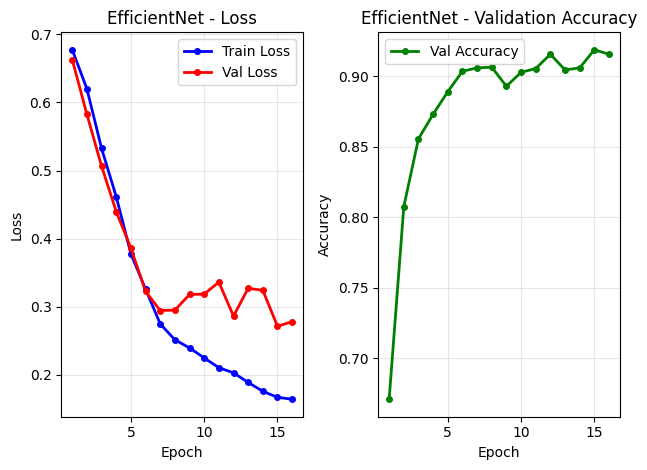


===== EPOCH 17/30 =====
EfficientNet LR for epoch 17: 1.00e-06

Training EfficientNet for Epoch 17...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 17 | Batch 50/1063 | Loss 0.726283


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 100/1063 | Loss 0.071450


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 17 | Batch 150/1063 | Loss 0.097310


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 200/1063 | Loss 0.068477


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 250/1063 | Loss 0.275101


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 300/1063 | Loss 0.120541
Epoch 17 | Batch 350/1063 | Loss 0.319721


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 400/1063 | Loss 0.096982
Epoch 17 | Batch 450/1063 | Loss 0.156593
Epoch 17 | Batch 500/1063 | Loss 0.350297


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 550/1063 | Loss 0.065185


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 600/1063 | Loss 0.122672


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 650/1063 | Loss 0.126076
Epoch 17 | Batch 700/1063 | Loss 0.064875
Epoch 17 | Batch 750/1063 | Loss 0.085939
Epoch 17 | Batch 800/1063 | Loss 0.064242
Epoch 17 | Batch 850/1063 | Loss 0.190865
Epoch 17 | Batch 900/1063 | Loss 0.324993
Epoch 17 | Batch 950/1063 | Loss 0.399122
Epoch 17 | Batch 1000/1063 | Loss 0.060035
Epoch 17 | Batch 1050/1063 | Loss 0.076771
Validating EfficientNet for Epoch 17...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 17/30 | Train Loss: 0.147406 | Val Acc: 0.908959 | Val Loss: 0.293091


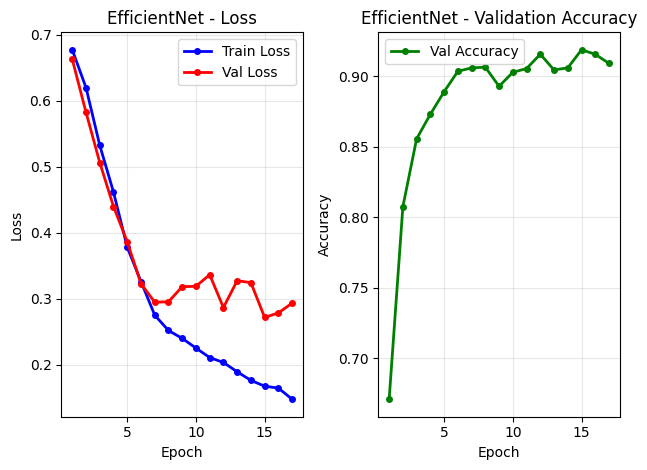


===== EPOCH 18/30 =====
EfficientNet LR for epoch 18: 1.00e-06

Training EfficientNet for Epoch 18...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 18 | Batch 50/1063 | Loss 0.057746


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 100/1063 | Loss 0.160107


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 150/1063 | Loss 0.095036


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 200/1063 | Loss 0.123498


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 18 | Batch 250/1063 | Loss 0.112040
Epoch 18 | Batch 300/1063 | Loss 0.102798


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 350/1063 | Loss 0.058705
Epoch 18 | Batch 400/1063 | Loss 0.059147
Epoch 18 | Batch 450/1063 | Loss 0.070502


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 500/1063 | Loss 0.261243


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 550/1063 | Loss 0.098242


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 600/1063 | Loss 0.068201
Epoch 18 | Batch 650/1063 | Loss 0.276637
Epoch 18 | Batch 700/1063 | Loss 0.141889
Epoch 18 | Batch 750/1063 | Loss 0.121333


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 800/1063 | Loss 0.247465
Epoch 18 | Batch 850/1063 | Loss 0.059901
Epoch 18 | Batch 900/1063 | Loss 0.077599
Epoch 18 | Batch 950/1063 | Loss 0.204444
Epoch 18 | Batch 1000/1063 | Loss 0.076956
Epoch 18 | Batch 1050/1063 | Loss 0.059359
Validating EfficientNet for Epoch 18...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 18/30 | Train Loss: 0.138440 | Val Acc: 0.907510 | Val Loss: 0.306643


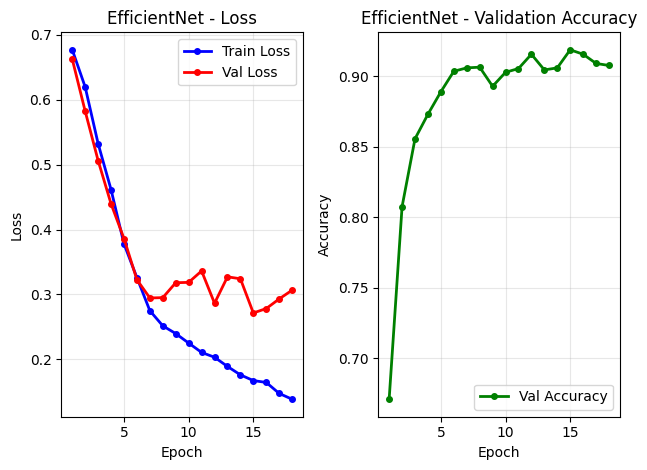


===== EPOCH 19/30 =====
EfficientNet LR for epoch 19: 1.00e-06

Training EfficientNet for Epoch 19...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 50/1063 | Loss 0.090347


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 19 | Batch 100/1063 | Loss 0.066695


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 150/1063 | Loss 0.272052


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 200/1063 | Loss 0.059840


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 19 | Batch 250/1063 | Loss 0.257354


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 300/1063 | Loss 0.127280


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 350/1063 | Loss 0.234732


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 400/1063 | Loss 0.065265
Epoch 19 | Batch 450/1063 | Loss 0.075247


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 500/1063 | Loss 0.193990


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 550/1063 | Loss 0.119846


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 600/1063 | Loss 0.338765


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 650/1063 | Loss 0.374340


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 700/1063 | Loss 0.085372
Epoch 19 | Batch 750/1063 | Loss 0.302328
Epoch 19 | Batch 800/1063 | Loss 0.083531


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 850/1063 | Loss 0.199627
Epoch 19 | Batch 900/1063 | Loss 0.061964


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 950/1063 | Loss 0.087341
Epoch 19 | Batch 1000/1063 | Loss 0.160062
Epoch 19 | Batch 1050/1063 | Loss 0.072024
Validating EfficientNet for Epoch 19...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 19/30 | Train Loss: 0.144712 | Val Acc: 0.906061 | Val Loss: 0.309090


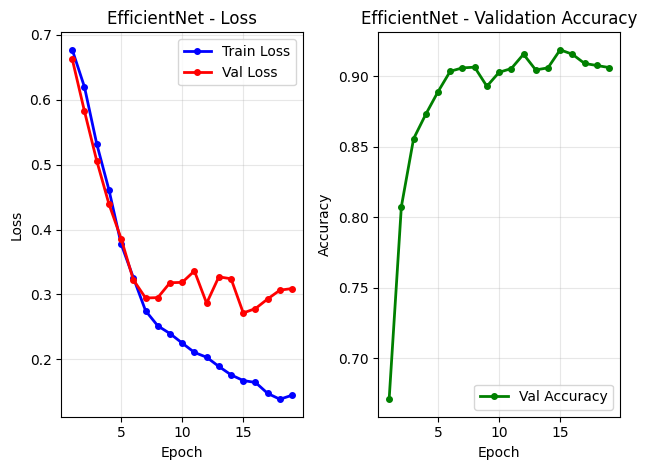


===== EPOCH 20/30 =====
EfficientNet LR for epoch 20: 1.00e-06

Training EfficientNet for Epoch 20...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 20 | Batch 50/1063 | Loss 0.089401


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 20 | Batch 100/1063 | Loss 0.237488


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 150/1063 | Loss 0.128054


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 20 | Batch 200/1063 | Loss 0.080328


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 250/1063 | Loss 0.213803


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 300/1063 | Loss 0.088189
Epoch 20 | Batch 350/1063 | Loss 0.059656


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 400/1063 | Loss 0.115911


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 450/1063 | Loss 0.152330


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 500/1063 | Loss 0.058230
Epoch 20 | Batch 550/1063 | Loss 0.059638
Epoch 20 | Batch 600/1063 | Loss 0.152757


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 650/1063 | Loss 0.205417
Epoch 20 | Batch 700/1063 | Loss 0.057926


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 750/1063 | Loss 0.354374
Epoch 20 | Batch 800/1063 | Loss 0.067206
Epoch 20 | Batch 850/1063 | Loss 0.228868


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 900/1063 | Loss 0.066151
Epoch 20 | Batch 950/1063 | Loss 0.083544
Epoch 20 | Batch 1000/1063 | Loss 0.057808
Epoch 20 | Batch 1050/1063 | Loss 0.319978
Validating EfficientNet for Epoch 20...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 20/30 | Train Loss: 0.127496 | Val Acc: 0.906303 | Val Loss: 0.306012


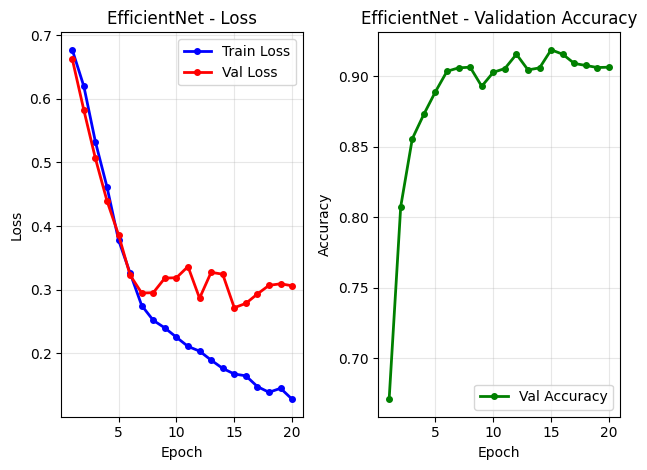


===== EPOCH 21/30 =====
EfficientNet LR for epoch 21: 1.00e-06

Training EfficientNet for Epoch 21...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 21 | Batch 50/1063 | Loss 0.068147


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 21 | Batch 100/1063 | Loss 0.071819


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 150/1063 | Loss 0.072178


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 200/1063 | Loss 0.075219


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 21 | Batch 250/1063 | Loss 0.150220


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 300/1063 | Loss 0.061507


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 350/1063 | Loss 0.062824


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 400/1063 | Loss 0.057898
Epoch 21 | Batch 450/1063 | Loss 0.060615


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 500/1063 | Loss 0.094734


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 550/1063 | Loss 0.094970
Epoch 21 | Batch 600/1063 | Loss 0.073088


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 650/1063 | Loss 0.463093
Epoch 21 | Batch 700/1063 | Loss 0.058917


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 750/1063 | Loss 0.160206
Epoch 21 | Batch 800/1063 | Loss 0.176316
Epoch 21 | Batch 850/1063 | Loss 0.095350
Epoch 21 | Batch 900/1063 | Loss 0.058993
Epoch 21 | Batch 950/1063 | Loss 0.060961
Epoch 21 | Batch 1000/1063 | Loss 0.057635
Epoch 21 | Batch 1050/1063 | Loss 0.083785
Validating EfficientNet for Epoch 21...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 21/30 | Train Loss: 0.125743 | Val Acc: 0.909684 | Val Loss: 0.305468


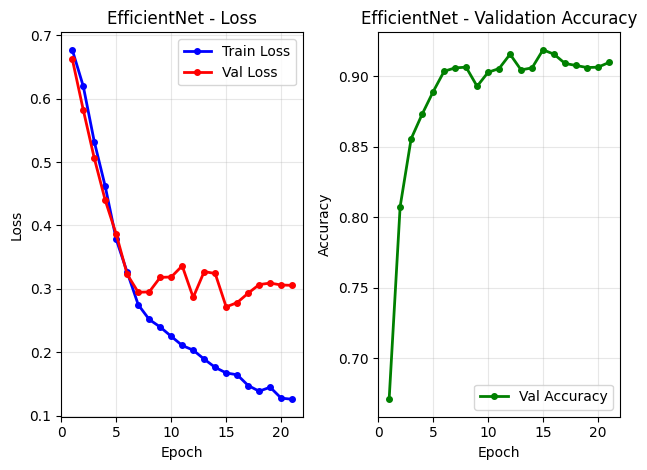


===== EPOCH 22/30 =====
EfficientNet LR for epoch 22: 1.00e-06

Training EfficientNet for Epoch 22...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 22 | Batch 50/1063 | Loss 0.081058


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 100/1063 | Loss 0.095302


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 22 | Batch 150/1063 | Loss 0.115642


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 22 | Batch 200/1063 | Loss 0.089255


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 250/1063 | Loss 0.206144


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 300/1063 | Loss 0.062676
Epoch 22 | Batch 350/1063 | Loss 0.333973


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 400/1063 | Loss 0.061908
Epoch 22 | Batch 450/1063 | Loss 0.074950


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 500/1063 | Loss 0.087716


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 550/1063 | Loss 0.066940


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 600/1063 | Loss 0.090126


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 650/1063 | Loss 0.246659
Epoch 22 | Batch 700/1063 | Loss 0.117595
Epoch 22 | Batch 750/1063 | Loss 0.065230
Epoch 22 | Batch 800/1063 | Loss 0.095211
Epoch 22 | Batch 850/1063 | Loss 0.057551
Epoch 22 | Batch 900/1063 | Loss 0.058586
Epoch 22 | Batch 950/1063 | Loss 0.144155
Epoch 22 | Batch 1000/1063 | Loss 0.063283
Epoch 22 | Batch 1050/1063 | Loss 0.172294
Validating EfficientNet for Epoch 22...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 22/30 | Train Loss: 0.119965 | Val Acc: 0.908718 | Val Loss: 0.299888


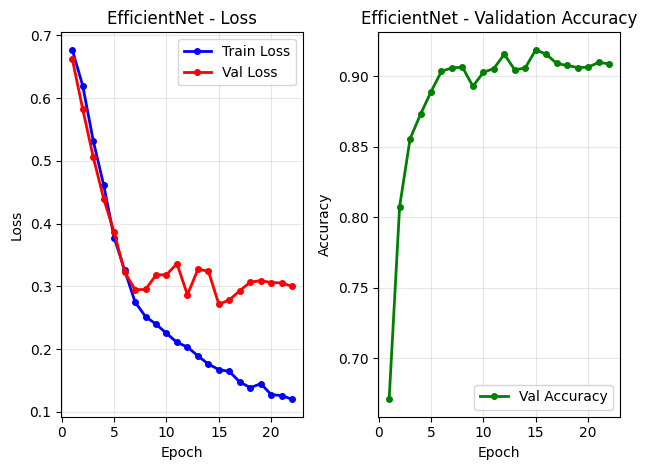


===== EPOCH 23/30 =====
EfficientNet LR for epoch 23: 1.00e-06

Training EfficientNet for Epoch 23...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 50/1063 | Loss 0.065319


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 23 | Batch 100/1063 | Loss 0.190181


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 150/1063 | Loss 0.346960


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 200/1063 | Loss 0.148997


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 23 | Batch 250/1063 | Loss 0.065350


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 300/1063 | Loss 0.138193


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 350/1063 | Loss 0.059775
Epoch 23 | Batch 400/1063 | Loss 0.092530


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 450/1063 | Loss 0.170767


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 500/1063 | Loss 0.063074


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 550/1063 | Loss 0.061233


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 600/1063 | Loss 0.061000
Epoch 23 | Batch 650/1063 | Loss 0.149488


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 700/1063 | Loss 0.275085
Epoch 23 | Batch 750/1063 | Loss 0.066542
Epoch 23 | Batch 800/1063 | Loss 0.423483
Epoch 23 | Batch 850/1063 | Loss 0.061089
Epoch 23 | Batch 900/1063 | Loss 0.135649
Epoch 23 | Batch 950/1063 | Loss 0.103846
Epoch 23 | Batch 1000/1063 | Loss 0.058598
Epoch 23 | Batch 1050/1063 | Loss 0.286127
Validating EfficientNet for Epoch 23...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 23/30 | Train Loss: 0.119552 | Val Acc: 0.903405 | Val Loss: 0.325568


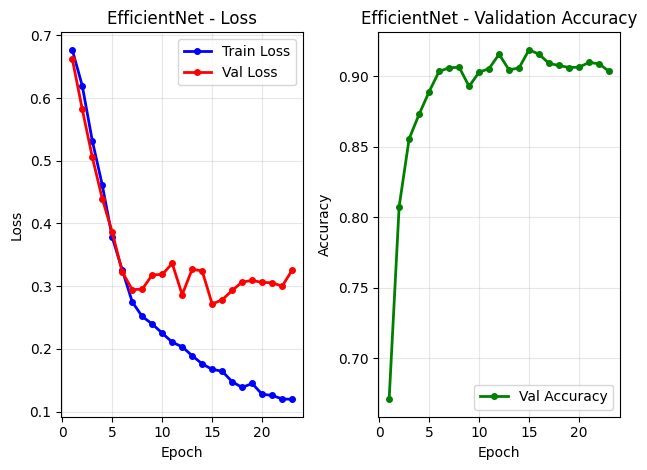


===== EPOCH 24/30 =====
EfficientNet LR for epoch 24: 1.00e-06

Training EfficientNet for Epoch 24...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 24 | Batch 50/1063 | Loss 0.058545


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 24 | Batch 100/1063 | Loss 0.059406


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 150/1063 | Loss 0.097551


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 200/1063 | Loss 0.058512


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 250/1063 | Loss 0.059143
Epoch 24 | Batch 300/1063 | Loss 0.082859


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 350/1063 | Loss 0.151379


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 400/1063 | Loss 0.519684


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 450/1063 | Loss 0.079057


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 500/1063 | Loss 0.062507


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 550/1063 | Loss 0.061298


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 600/1063 | Loss 0.305593


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 650/1063 | Loss 0.109304
Epoch 24 | Batch 700/1063 | Loss 0.069017
Epoch 24 | Batch 750/1063 | Loss 0.318254
Epoch 24 | Batch 800/1063 | Loss 0.102235
Epoch 24 | Batch 850/1063 | Loss 0.127290
Epoch 24 | Batch 900/1063 | Loss 0.060974
Epoch 24 | Batch 950/1063 | Loss 0.079060


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 1000/1063 | Loss 0.105837
Epoch 24 | Batch 1050/1063 | Loss 0.100577
Validating EfficientNet for Epoch 24...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 24/30 | Train Loss: 0.116954 | Val Acc: 0.905820 | Val Loss: 0.338402


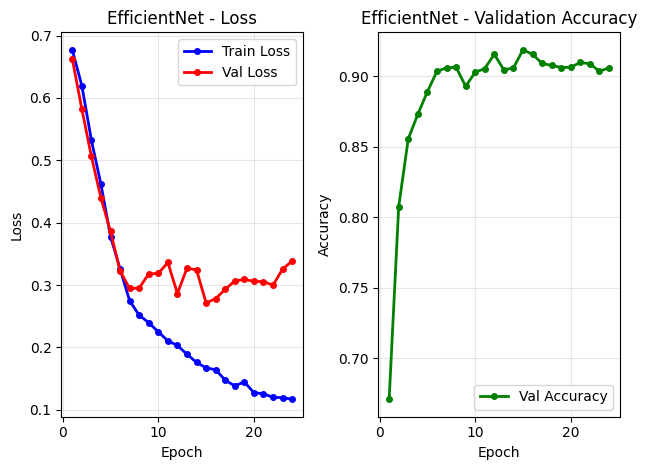


===== EPOCH 25/30 =====
EfficientNet LR for epoch 25: 1.00e-06

Training EfficientNet for Epoch 25...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 25 | Batch 50/1063 | Loss 0.091099


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 100/1063 | Loss 0.060575


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 150/1063 | Loss 0.059035


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 200/1063 | Loss 0.087923


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 250/1063 | Loss 0.155999


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 25 | Batch 300/1063 | Loss 0.102282


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 350/1063 | Loss 0.069094


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 400/1063 | Loss 0.061168


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 450/1063 | Loss 0.317696


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 500/1063 | Loss 0.059139


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 550/1063 | Loss 0.090240


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 600/1063 | Loss 0.073114


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 650/1063 | Loss 0.059039
Epoch 25 | Batch 700/1063 | Loss 0.059420
Epoch 25 | Batch 750/1063 | Loss 0.060133
Epoch 25 | Batch 800/1063 | Loss 0.092253
Epoch 25 | Batch 850/1063 | Loss 0.066287


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 900/1063 | Loss 0.064474
Epoch 25 | Batch 950/1063 | Loss 0.292905
Epoch 25 | Batch 1000/1063 | Loss 0.061766
Epoch 25 | Batch 1050/1063 | Loss 0.060886
Validating EfficientNet for Epoch 25...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 25/30 | Train Loss: 0.109141 | Val Acc: 0.912582 | Val Loss: 0.312062


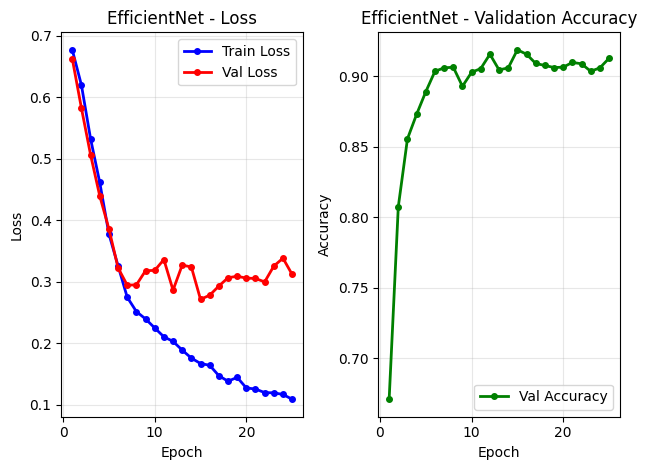


===== EPOCH 26/30 =====
EfficientNet LR for epoch 26: 1.00e-06

Training EfficientNet for Epoch 26...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 26 | Batch 50/1063 | Loss 0.084634


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 26 | Batch 100/1063 | Loss 0.059303


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 150/1063 | Loss 0.085592


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 200/1063 | Loss 0.101477


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 250/1063 | Loss 0.101033


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 300/1063 | Loss 0.120696


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 350/1063 | Loss 0.058587
Epoch 26 | Batch 400/1063 | Loss 0.059852


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 450/1063 | Loss 0.057187


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 500/1063 | Loss 0.058349


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 550/1063 | Loss 0.057348
Epoch 26 | Batch 600/1063 | Loss 0.058839
Epoch 26 | Batch 650/1063 | Loss 0.069557
Epoch 26 | Batch 700/1063 | Loss 0.061827
Epoch 26 | Batch 750/1063 | Loss 0.058410
Epoch 26 | Batch 800/1063 | Loss 0.058035


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 850/1063 | Loss 0.058034
Epoch 26 | Batch 900/1063 | Loss 0.057381
Epoch 26 | Batch 950/1063 | Loss 0.062463
Epoch 26 | Batch 1000/1063 | Loss 0.282886
Epoch 26 | Batch 1050/1063 | Loss 0.190407
Validating EfficientNet for Epoch 26...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 26/30 | Train Loss: 0.105264 | Val Acc: 0.901956 | Val Loss: 0.338684


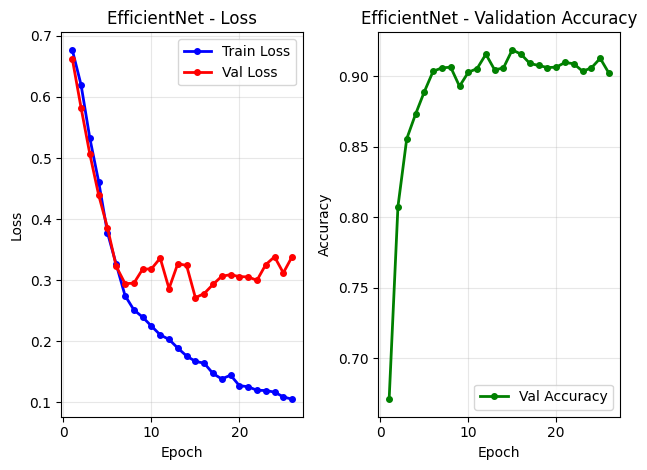


===== EPOCH 27/30 =====
EfficientNet LR for epoch 27: 1.00e-06

Training EfficientNet for Epoch 27...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 50/1063 | Loss 0.143795


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 27 | Batch 100/1063 | Loss 0.062215


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 150/1063 | Loss 0.060369


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 27 | Batch 200/1063 | Loss 0.199521


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 250/1063 | Loss 0.061311


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 300/1063 | Loss 0.109109


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 350/1063 | Loss 0.070228


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 400/1063 | Loss 0.064164
Epoch 27 | Batch 450/1063 | Loss 0.064298
Epoch 27 | Batch 500/1063 | Loss 0.058496
Epoch 27 | Batch 550/1063 | Loss 0.086076


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 600/1063 | Loss 0.058227


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 650/1063 | Loss 0.083050


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 700/1063 | Loss 0.057672
Epoch 27 | Batch 750/1063 | Loss 0.057754


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 800/1063 | Loss 0.058671
Epoch 27 | Batch 850/1063 | Loss 0.178193
Epoch 27 | Batch 900/1063 | Loss 0.059581
Epoch 27 | Batch 950/1063 | Loss 0.064239
Epoch 27 | Batch 1000/1063 | Loss 0.058999
Epoch 27 | Batch 1050/1063 | Loss 0.275866
Validating EfficientNet for Epoch 27...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 27/30 | Train Loss: 0.099336 | Val Acc: 0.918377 | Val Loss: 0.299654


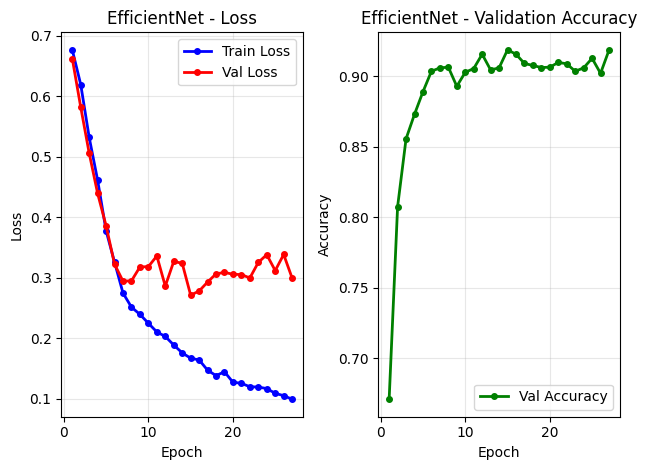


===== EPOCH 28/30 =====
EfficientNet LR for epoch 28: 1.00e-06

Training EfficientNet for Epoch 28...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 28 | Batch 50/1063 | Loss 0.267253


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 28 | Batch 100/1063 | Loss 0.060111


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 150/1063 | Loss 0.058179


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 200/1063 | Loss 0.057739


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 250/1063 | Loss 0.057921


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 300/1063 | Loss 0.056980


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 350/1063 | Loss 0.059766


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 400/1063 | Loss 0.059673


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 450/1063 | Loss 0.229677


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 500/1063 | Loss 0.057507


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 550/1063 | Loss 0.057400
Epoch 28 | Batch 600/1063 | Loss 0.124293
Epoch 28 | Batch 650/1063 | Loss 0.197198


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 700/1063 | Loss 0.524211
Epoch 28 | Batch 750/1063 | Loss 0.072869
Epoch 28 | Batch 800/1063 | Loss 0.057661
Epoch 28 | Batch 850/1063 | Loss 0.058707
Epoch 28 | Batch 900/1063 | Loss 0.267038
Epoch 28 | Batch 950/1063 | Loss 0.100442
Epoch 28 | Batch 1000/1063 | Loss 0.058711
Epoch 28 | Batch 1050/1063 | Loss 0.099095
Validating EfficientNet for Epoch 28...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 28/30 | Train Loss: 0.101050 | Val Acc: 0.907269 | Val Loss: 0.321474


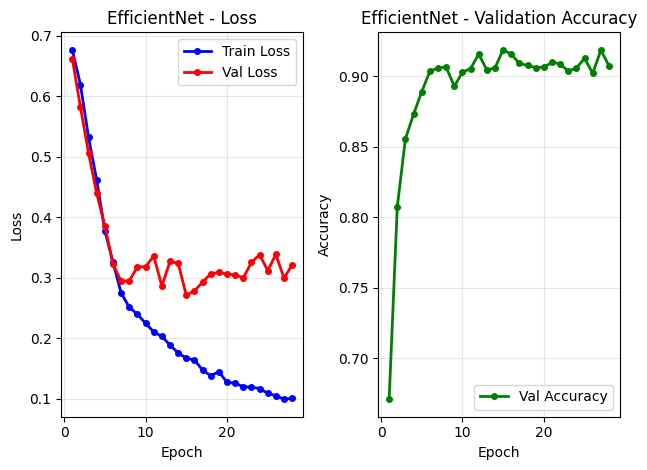


===== EPOCH 29/30 =====
EfficientNet LR for epoch 29: 1.00e-06

Training EfficientNet for Epoch 29...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 50/1063 | Loss 0.062615


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 29 | Batch 100/1063 | Loss 0.057652


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 29 | Batch 150/1063 | Loss 0.058193


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 200/1063 | Loss 0.143909


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 29 | Batch 250/1063 | Loss 0.056707


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 300/1063 | Loss 0.078246


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 350/1063 | Loss 0.057641


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 400/1063 | Loss 0.071245


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 450/1063 | Loss 0.251077
Epoch 29 | Batch 500/1063 | Loss 0.064814


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 550/1063 | Loss 0.090648
Epoch 29 | Batch 600/1063 | Loss 0.057600


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 650/1063 | Loss 0.146503
Epoch 29 | Batch 700/1063 | Loss 0.066206
Epoch 29 | Batch 750/1063 | Loss 0.695910
Epoch 29 | Batch 800/1063 | Loss 0.061342
Epoch 29 | Batch 850/1063 | Loss 0.197011
Epoch 29 | Batch 900/1063 | Loss 0.080651
Epoch 29 | Batch 950/1063 | Loss 0.058984
Epoch 29 | Batch 1000/1063 | Loss 0.063814
Epoch 29 | Batch 1050/1063 | Loss 0.120204
Validating EfficientNet for Epoch 29...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 29/30 | Train Loss: 0.097736 | Val Acc: 0.910167 | Val Loss: 0.317079


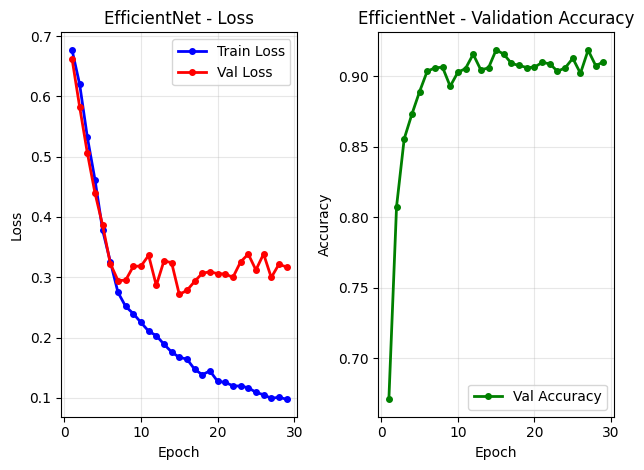


===== EPOCH 30/30 =====
EfficientNet LR for epoch 30: 1.00e-06

Training EfficientNet for Epoch 30...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 50/1063 | Loss 0.141087


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 100/1063 | Loss 0.252033


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 30 | Batch 150/1063 | Loss 0.069525


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 200/1063 | Loss 0.057270


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 250/1063 | Loss 0.061041


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 300/1063 | Loss 0.056658


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 350/1063 | Loss 0.057071


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 400/1063 | Loss 0.059164


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 450/1063 | Loss 0.056430
Epoch 30 | Batch 500/1063 | Loss 0.149527


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 550/1063 | Loss 0.057401


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 600/1063 | Loss 0.132982
Epoch 30 | Batch 650/1063 | Loss 0.560753


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 700/1063 | Loss 0.057479
Epoch 30 | Batch 750/1063 | Loss 0.125143
Epoch 30 | Batch 800/1063 | Loss 0.057057
Epoch 30 | Batch 850/1063 | Loss 0.056849
Epoch 30 | Batch 900/1063 | Loss 0.057137
Epoch 30 | Batch 950/1063 | Loss 0.059322
Epoch 30 | Batch 1000/1063 | Loss 0.061191
Epoch 30 | Batch 1050/1063 | Loss 0.057231
Validating EfficientNet for Epoch 30...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation class distribution: 2014/4141 positives
RESULTS: EfficientNet | Epoch 30/30 | Train Loss: 0.094471 | Val Acc: 0.909925 | Val Loss: 0.321379


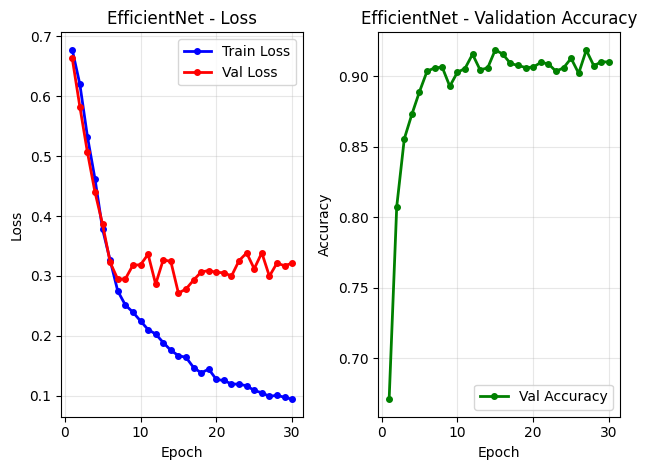

In [6]:
EPOCHS = 30
PATIENCE_REDUCE_LR = 5

# Metrics tracking
train_metrics = []
val_metrics = []
val_loss_metrics = []

print(f"\n--- Starting EfficientNet Training for {EPOCHS} Epochs ---")

# Enable interactive plotting
plt.ion()

for epoch in range(EPOCHS):
    print(f"\n===== EPOCH {epoch + 1}/{EPOCHS} =====")
    
    # Apply warmup scheduler
    current_lr = warmup_scheduler.step(epoch)
    print(f"EfficientNet LR for epoch {epoch + 1}: {current_lr:.2e}")
    
    # Training
    print(f"\nTraining EfficientNet for Epoch {epoch + 1}...")
    train_loss_epoch, _, _ = train_one_epoch(model, train_loader, optimizer, epoch, print_every=50)

    # Validation
    print(f"Validating EfficientNet for Epoch {epoch + 1}...")
    val_acc_epoch, val_loss_epoch = eval_dataset_with_loss(model, val_loader, loss_fn)

    # Switch to ReduceLROnPlateau after warmup
    if epoch == 5:
        print("Warmup complete! Switching to ReduceLROnPlateau scheduler...")
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=PATIENCE_REDUCE_LR, verbose=True
        )
    
    # Step the plateau scheduler after warmup
    if epoch > 5:
        plateau_scheduler.step(train_loss_epoch)
    
    # Log results
    log_message = f"RESULTS: EfficientNet | Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss_epoch:.6f} | Val Acc: {val_acc_epoch:.6f} | Val Loss: {val_loss_epoch:.6f}"
    print(log_message)
    
    # Store metrics
    train_metrics.append(train_loss_epoch)
    val_metrics.append(val_acc_epoch)
    val_loss_metrics.append(val_loss_epoch)

    # Real-time plotting
    plt.clf()
    epochs_so_far = list(range(1, epoch + 2))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_so_far, train_metrics, 'b-o', label='Train Loss', linewidth=2, markersize=4)
    plt.plot(epochs_so_far, val_loss_metrics, 'r-o', label='Val Loss', linewidth=2, markersize=4)
    plt.title('EfficientNet - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_so_far, val_metrics, 'g-o', label='Val Accuracy', linewidth=2, markersize=4)
    plt.title('EfficientNet - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)

# Keep the final plot displayed
plt.ioff()
plt.show()

## 7. Save Results and Model


--- Saving EfficientNet Training Results ---
Detailed results saved to /kaggle/working/Training Data/efficientnet_results_2025-09-17_04-46-59_run5.json
Model weights saved to /kaggle/working/model/efficientnet_b5_normalized_2025-09-17_04-46-59_run5.pth

--- EfficientNet training with normalization complete! ---

--- Starting Detailed Evaluation ---


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



=== EFFICIENTNET PATCH-LEVEL EVALUATION ===
ROC-AUC: 0.963   PR-AUC (AP): 0.945
              precision    recall  f1-score   support

   authentic       0.90      0.93      0.91      2127
   imitation       0.93      0.89      0.91      2014

    accuracy                           0.91      4141
   macro avg       0.91      0.91      0.91      4141
weighted avg       0.91      0.91      0.91      4141



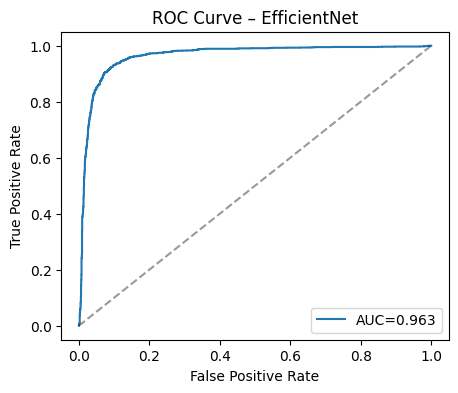

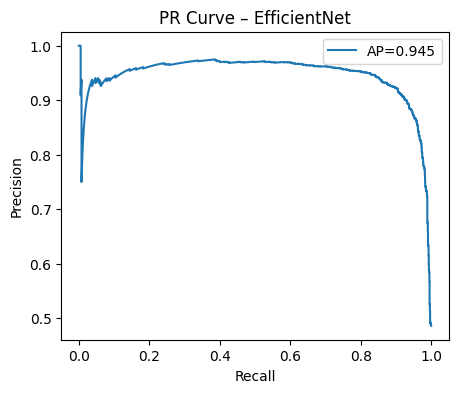

In [7]:
print("\n--- Saving EfficientNet Training Results ---")
current_timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_training_results('efficientnet', train_metrics, val_metrics, val_loss_metrics, current_timestamp)

# Save model
model_save_path = f"/kaggle/working/model/efficientnet_b5_normalized_{current_timestamp}_run5.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

print("\n--- EfficientNet training with normalization complete! ---")

# 8. Detailed Evaluation Metrics & Curves
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import torch.nn.functional as F

print("\n--- Starting Detailed Evaluation ---")

model.eval()
y_true, y_scores = [], []

# Gather ground-truth & predicted "imitation" probabilities
with torch.no_grad():
    for x, y, _ in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)[:, 1]      # P(imitation)
        y_true.extend(y.cpu().numpy().tolist())
        y_scores.extend(probs.cpu().numpy().tolist())

# Binarize predictions at 0.5
y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

# Compute metrics
auc = roc_auc_score(y_true, y_scores)
ap  = average_precision_score(y_true, y_scores)
print(f"\n=== EFFICIENTNET PATCH-LEVEL EVALUATION ===")
print(f"ROC-AUC: {auc:.3f}   PR-AUC (AP): {ap:.3f}")
print(classification_report(
    y_true, y_pred,
    target_names=['authentic','imitation']
))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.title(f'ROC Curve – EfficientNet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.title(f'PR Curve – EfficientNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## 9. Painting-level Evaluation with Majority Voting

In [8]:
print("\n--- Starting Painting-level Evaluation ---")
import numpy as np
from sklearn.metrics import accuracy_score

# Collect patch-level data
painting_ids, true_labels = [], []
effnet_probs = []

for x, y, pid in val_loader:
    x = x.to(device)
    with torch.no_grad():
        e_logits = model(x)
        e_p = F.softmax(e_logits, dim=1)[:, 1].cpu().numpy()
    painting_ids.extend(pid.numpy())
    true_labels.extend(y.numpy())
    effnet_probs.extend(e_p)

# Aggregate per painting
paintings = defaultdict(list)
for pid, y, p1 in zip(painting_ids, true_labels, effnet_probs):
    paintings[pid].append((y, p1))

painting_true = []
paint_eff_major = []
paint_eff_avg = []

for pid, patches in paintings.items():
    y_true = patches[0][0]
    p1_list = [t[1] for t in patches]
    
    # Majority vote at 0.5 threshold
    v1 = [int(p>=0.5) for p in p1_list]
    
    # Average probability approach
    avg_prob = np.mean(p1_list)

    painting_true.append(y_true)
    paint_eff_major.append(Counter(v1).most_common(1)[0][0])
    paint_eff_avg.append(int(avg_prob >= 0.5))

# Report painting-level metrics
print("=== PAINTING-LEVEL METRICS ===")

print(f"\nEfficientNet-majority:")
print("Accuracy:", accuracy_score(painting_true, paint_eff_major))
print(classification_report(
    painting_true, paint_eff_major,
    target_names=['authentic','imitation']
))

print(f"\nEfficientNet-avgprob:")
print("Accuracy:", accuracy_score(painting_true, paint_eff_avg))
print(classification_report(
    painting_true, paint_eff_avg,
    target_names=['authentic','imitation']
))

print("\n--- Complete evaluation finished! ---")


--- Starting Painting-level Evaluation ---


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


=== PAINTING-LEVEL METRICS ===

EfficientNet-majority:
Accuracy: 0.9154929577464789
              precision    recall  f1-score   support

   authentic       0.90      0.93      0.92       177
   imitation       0.93      0.90      0.91       178

    accuracy                           0.92       355
   macro avg       0.92      0.92      0.92       355
weighted avg       0.92      0.92      0.92       355


EfficientNet-avgprob:
Accuracy: 0.9352112676056338
              precision    recall  f1-score   support

   authentic       0.92      0.95      0.94       177
   imitation       0.95      0.92      0.93       178

    accuracy                           0.94       355
   macro avg       0.94      0.94      0.94       355
weighted avg       0.94      0.94      0.94       355


--- Complete evaluation finished! ---
